In [1]:
%matplotlib inline
import cantera as ct
import numpy as np
import os
import sys
import matplotlib.pyplot as plt
import pickle
import copy

In [2]:
# these lines can be replaced by any commands that generate
# an object of a class derived from class Kinetics in some state.
gas_sk20 = ct.Solution('CH4_SK20_Jaravel.xml')
gas_gri30 = ct.Solution('gri30.cti')
gas_bulk = ct.Solution('CH4_RED15_Jaravel.xml', 'reduced')
gas_qss = ct.Solution('CH4_RED15_Jaravel.xml', 'QSS', [gas_bulk])

In [3]:
def diffusion_flame(gas, kin, alpha, fuel, oxy, p, prefix):
    width = 0.04 # Distance between inlets is 2 cm
    loglevel = 1  # amount of diagnostic output (0 to 5)
    
    # Create the gas object used to evaluate all thermodynamic, kinetic, and
    # transport properties.
    gas.TP = gas.T, p
    
    # Create an object representing the counterflow flame configuration,
    # which consists of a fuel inlet on the left, the flow in the middle,
    # and the oxidizer inlet on the right.
    f = ct.CounterflowDiffusionFlame(gas, width=width)
    f.set_kin(kin)
    
    # Set the state of the two inlets
    f.fuel_inlet.X = fuel['X']
    f.fuel_inlet.T = fuel['T']
    
    f.oxidizer_inlet.X = oxy['X']
    f.oxidizer_inlet.T = oxy['T']
    
    # Set the boundary emissivities
    f.set_boundary_emissivities(0.0, 0.0)
    # Turn radiation off
    f.radiation_enabled = False
    
    f.set_refine_criteria(ratio=4, slope=0.2, curve=0.3, prune=0.04)
    
    flist = []
    
    for a in alpha:        
        # Input parameters
        # Oxy
        gas.TPX = oxy['T'], p, oxy['X']
        rho_o = gas.density
        # Fuel
        gas.TPX = fuel['T'], p, fuel['X']
        rho_f = gas.density
        # Mass flow rate
        mdot_f = rho_f * a * width / (1 + np.sqrt(rho_f / rho_o))
        mdot_o = rho_o * a * width / (1 + np.sqrt(rho_o / rho_f))

        # Set the state of the two inlets
        f.fuel_inlet.mdot = mdot_f

        f.oxidizer_inlet.mdot = mdot_o

        # Solve the problem
        f.energy_enabled = True
        f.solve(loglevel, auto=(a==alpha[0]))
        f.save('%s_a%.2e_t%.2f_diffusion.xml' % (prefix, a, np.max(f.T)))
        
        flist.append([f.grid, f.T, f.Y])
    return flist

In [4]:
alpha = np.logspace(np.log10(10), np.log10(400), 50)
f_red15 = diffusion_flame(gas_bulk, gas_qss, alpha, 
                          {'T': 298, 'X': 'CH4: 1.0'}, 
                          {'T': 298, 'X': 'O2:0.21, N2:0.78'}, 
                          ct.one_atm, 'save/red15')
f_sk20 = diffusion_flame(gas_sk20, gas_sk20, alpha, 
                         {'T': 298, 'X': 'CH4: 1.0'}, 
                         {'T': 298, 'X': 'O2:0.21, N2:0.78'}, 
                         ct.one_atm, 'save/sk20')
f_gri30 = diffusion_flame(gas_gri30, gas_gri30, alpha, 
                          {'T': 298, 'X': 'CH4: 1.0'}, 
                          {'T': 298, 'X': 'O2:0.21, N2:0.78'}, 
                          ct.one_atm, 'save/gri30')



************ Solving on 6 point grid with energy equation enabled ************

..............................................................................
Attempt Newton solution of steady-state problem...    failure. 
Take 10 timesteps     0.0001139      4.873
Attempt Newton solution of steady-state problem...    failure. 
Take 10 timesteps      0.001297      4.958
Attempt Newton solution of steady-state problem...    failure. 
Take 10 timesteps      0.002189      4.407
Attempt Newton solution of steady-state problem...    failure. 
Take 10 timesteps       0.01663      3.439
Attempt Newton solution of steady-state problem...    failure. 
Take 10 timesteps        0.1263      1.151
Attempt Newton solution of steady-state problem...    success.

Problem solved on [6] point grid(s).

..............................................................................
grid refinement disabled.

******************** Solving with grid refinement enabled ********************

.................

In [5]:
pickle.dump([f_red15, f_sk20, f_gri30], open('save.p', 'wb'))

In [6]:
T_red15 = [np.max(f[1]) for f in f_red15]
T_sk20 = [np.max(f[1]) for f in f_sk20]
T_gri30 = [np.max(f[1]) for f in f_gri30]

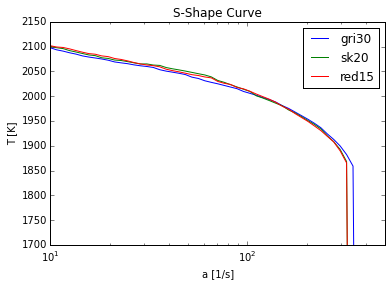

In [7]:
plt.figure()
plt.hold(True)
handle_gri30 = plt.semilogx(alpha, T_gri30, '-', label='gri30')
handle_sk20 = plt.semilogx(alpha, T_sk20, '-', label='sk20')
handle_red15 = plt.semilogx(alpha, T_red15, '-', label='red15')
plt.title('S-Shape Curve')
plt.ylim(1700, 2150)
plt.xlim(10, 500)
plt.xlabel('a [1/s]')
plt.ylabel('T [K]')
plt.legend()

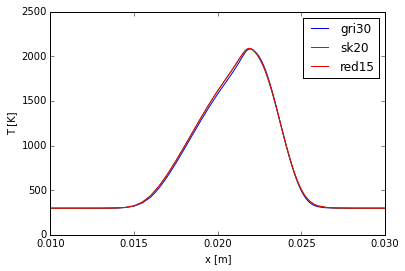

In [9]:
plt.figure()
plt.hold(True)
handle_gri30 = plt.plot(f_gri30[5][0], f_gri30[5][1], '-', label='gri30')
handle_sk20 = plt.plot(f_sk20[5][0], f_sk20[5][1], '-', label='sk20')
handle_red15 = plt.plot(f_red15[5][0], f_red15[5][1], '-', label='red15')
plt.xlim(0.01, 0.03)
plt.xlabel('x [m]')
plt.ylabel('T [K]')
plt.legend()

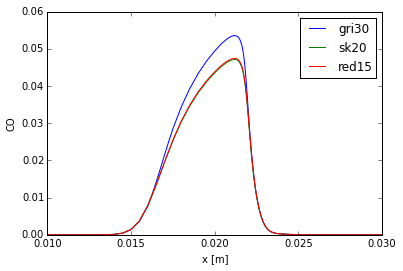

In [20]:
plt.figure()
plt.hold(True)
handle_gri30 = plt.plot(f_gri30[5][0], f_gri30[5][2][gas_gri30.species_index('CO')], '-', label='gri30')
handle_sk20 = plt.plot(f_sk20[5][0], f_sk20[5][2][gas_sk20.species_index('CO')], '-', label='sk20')
handle_red15 = plt.plot(f_red15[5][0], f_red15[5][2][gas_bulk.species_index('CO')], '-', label='red15')
plt.xlim(0.01, 0.03)
plt.xlabel('x [m]')
plt.ylabel('CO')
plt.legend()